## **Contrastive Learning**

This notebook demonstrates the implementation of `Contrastive Learning Siamese Network` using `Contrastive Loss`to if a pair of images are similar different. 

Yann le Cunn et al. in [Dimensionality Reduction by Learning an invariant Mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)" introduced contrastive Contrastive Loss.
![Siamese Network](siamese_network.png)

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
import keras

We begin by loading dataset from keras 

In [2]:
from keras import datasets

(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()

print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)
print("X_test.shape: ", X_test.shape)
print("y_test.shape: ", y_test.shape)

X_train.shape:  (60000, 28, 28)
y_train.shape:  (60000,)
X_test.shape:  (10000, 28, 28)
y_test.shape:  (10000,)


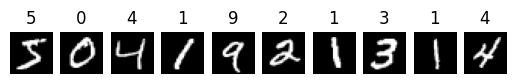

In [3]:
import matplotlib.pyplot as plt

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="gray")
    plt.title(y_train[i])
    plt.axis("off")

Considering each image is 28 by 28 pixels, we will create a neural network that recieves every pixel as an input. Thereby, reshaping the data to have a single array with `28 x 28 = 784` pixels.

In [4]:
X_train = X_train.reshape(-1, 784) # 28*28=784
X_test = X_test.reshape(-1, 784)  # 28*28=784

print("X_train.shape: ", X_train.shape)
print("X_test.shape: ", X_test.shape)

X_train.shape:  (60000, 784)
X_test.shape:  (10000, 784)


Normalizing the pixel values to range between 0 and 1 (instead of 0 to 255) using the min-max normalization formular:

i.e. X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())

For an image, X_train.min() = 0, and X_train.max() = 255.

Simplified as:
    X_train = X_train / 255.0

In [5]:
X_train = X_train / 255.0
X_test = X_test / 255.0

The Siamese Networkwill be trained using positive and negative pairs of images. A positive pair consists of two images representing the same digit, while negative pairs consists of images representing different digits

In [6]:
import numpy as np


def generate_pairs(X, y):
    """
    Creates a collection of positive and negative pairs for the given dataset

    A positive pair is a pair of samples that have the same label.
    A negative pair is a pair of samples that have different labels.
    """
    X_pairs = []
    y_pairs = []

    for i in range(len(X)):
        digit = y[i]

        # Find a random image of the same digit
        positive_index = np.random.choice(np.where(y == digit)[0])

        # Add the pair of images to the list
        X_pairs.append([X[i], X[positive_index]])

        # Considering that the pair is positive, the ground truth is 0.
        # The distance between images representing the same digit should be small.
        # Hence, the ground truth is 0.
        y_pairs.append([0])

        # Find a random image of a different digit
        negative_index = np.random.choice(np.where(y != digit)[0])

        # Add the pair of images to the list
        X_pairs.append([X[i], X[negative_index]])

        # Considering that the pair is negative, the ground truth is 1.
        # The distance between images representing different digits should be large.
        # Hence, the ground truth is 1.
        y_pairs.append([1])

    indices = np.arange(len(X_pairs))
    np.random.shuffle(indices)

    return np.array(X_pairs)[indices], np.array(y_pairs)[indices]

In [7]:
# Generate pairs for training and testing the model
X_train_pairs, y_train_pairs = generate_pairs(X_train, y_train)
X_test_pairs, y_test_pairs = generate_pairs(X_test, y_test)

print("X_train_pairs.shape: ", X_train_pairs.shape)
print("X_test_pairs.shape: ", X_test_pairs.shape)

X_train_pairs.shape:  (120000, 2, 784)
X_test_pairs.shape:  (20000, 2, 784)


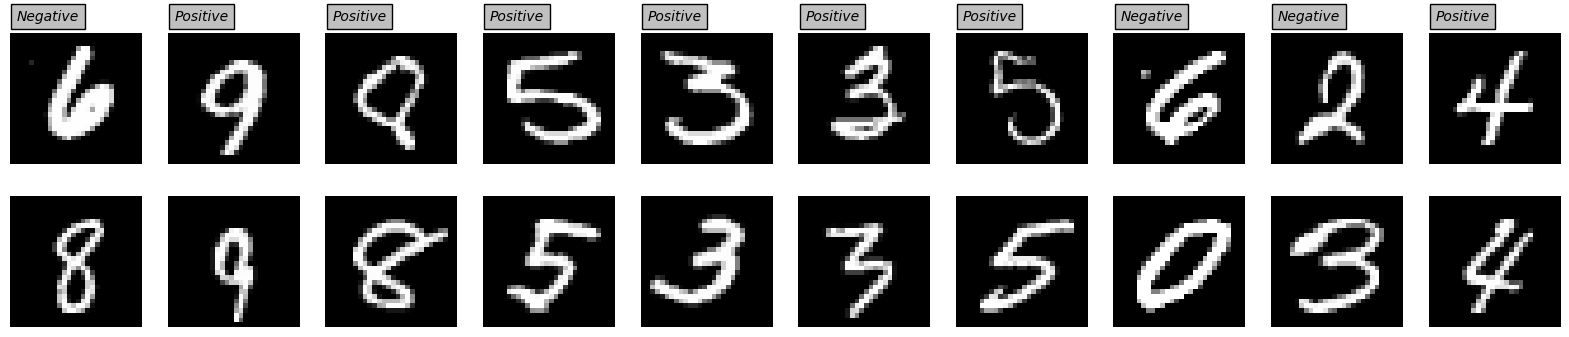

In [8]:
# Visualize the pairs
def visualize_pairs(X, y, correct=None):
    """
    Visualizes the pairs of images from the given dataset

    Args:
        X: An array of pairs of images
        y: An array containg the corresponding label (0 if both pairs are of the same digit, 1 otherwise)
        correct (optional): An array of boolean values indicating whether the supplied label is correctly
            represented in the image pairs.
    """
    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(X[:n, 0], X[:n, 1])):
        label = int(y[:n][i][0])

        text = "Positive" if label == 0 else "Negative"
        color = 'silver'

        # If the supplied label is correct, the title is green. Otherwise, it is red.
        if correct is not None:
            text = "Same digit" if label == 0 else "Different digits"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"

        ax = plt.subplot(3, n, i + 1) 
        ax.text(1, -3, text, style='italic', bbox={'facecolor': color, "pad": 4})
        plt.imshow(image1.reshape(28, 28), cmap="gray")
        plt.axis("off")

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.show()


visualize_pairs(X_train_pairs, y_train_pairs)

In [9]:
# Create a Siamese network
from keras import Input

input1 = Input(shape=(784,))
input2 = Input(shape=(784,))

In [10]:
# Define the shared model
from keras.layers import Dense
from keras.models import Sequential

shared_model = Sequential(
    [
        Input(shape=(784,)),
        Dense(512, activation="relu"),
        Dense(256, activation="relu"),
        Dense(128, activation=None),
    ]
)

In [11]:
twin1 = shared_model(input1)
twin2 = shared_model(input2)

The output of the network will be the distance between the embedding of two images. To achieve this, `Lambda` layer is used to calculate the Euclidean distance between the embeddings

In [12]:
from keras.layers import Lambda
from keras.ops import norm


def euclidean_distance(twins):
    """
    Computes the Euclidean distance between two vectors

    Args:
        twins: A list containing the two vectors

    Returns:
        The Euclidean distance between the two vectors
    """
    x, y = twins
    return norm(x - y, axis=1, keepdims=True)


distance = Lambda(euclidean_distance)([twin1, twin2])

In [13]:
# Define the model
from keras import Model

model = Model(inputs=[input1, input2], outputs=distance)

We'll use the `Contrastive Loss` to train the model. [Dimensionality Reduction by Leraning an Invariant Mapping](http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf)

<img src="contrastive_loss_formula.png" alt="Contrastive Loss Formula" width="50%">

In [14]:
from keras.ops import cast, maximum, square


def contrastive_loss(y, d):
    """
    Computes the contrastive loss
    """

    margin = 1
    y = cast(y, d.dtype)

    loss = (1 - y) / 2 * square(d) + y / 2 * square(maximum(0.0, margin - d))

    return loss

In [15]:
# Compile the model with the contrastive loss
model.compile(loss=contrastive_loss, optimizer="adam", metrics=["binary_accuracy"])

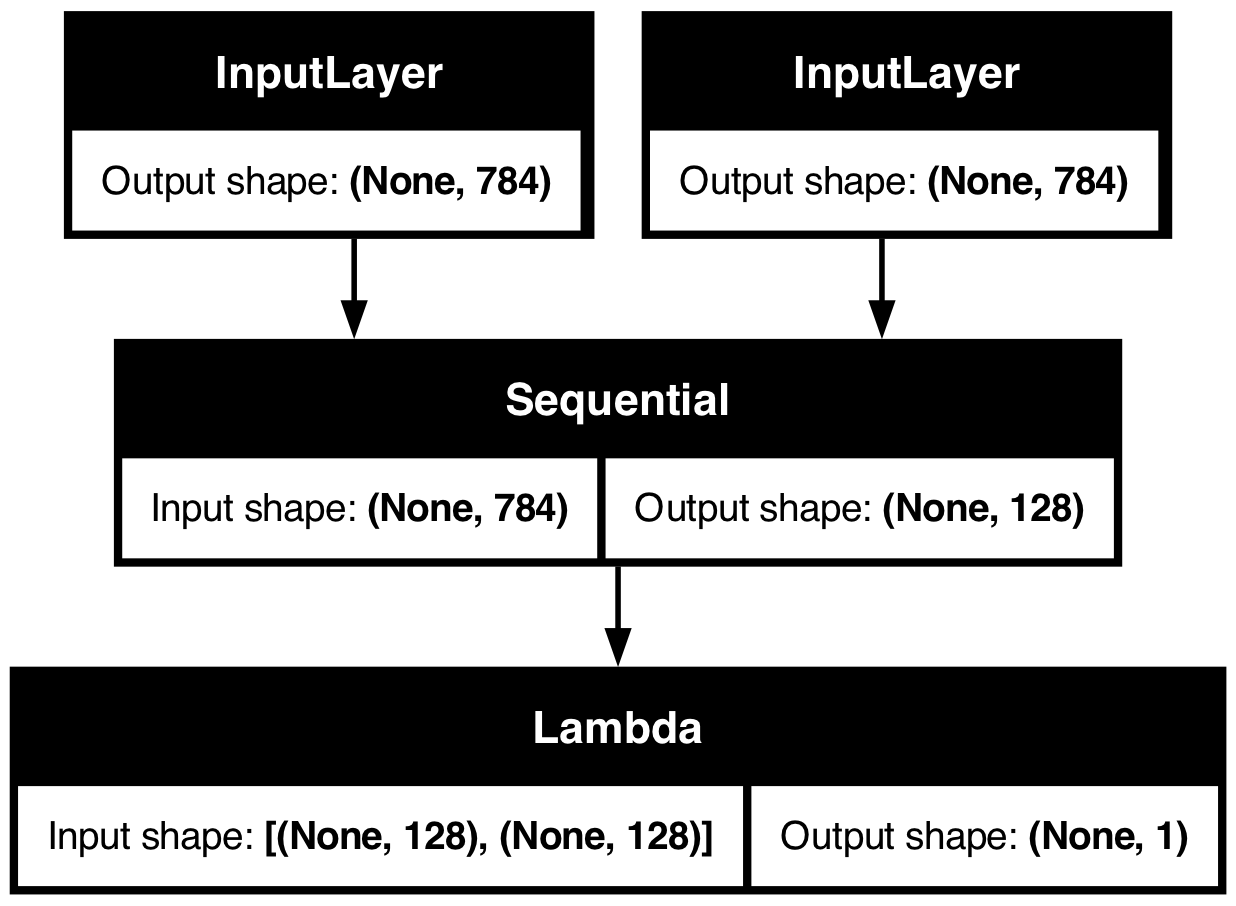

In [19]:
# Display the model architecture
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False)

In [20]:
history = model.fit(
    x=[X_train_pairs[:, 0], X_train_pairs[:, 1]],   # Input is a pair of images
    y=y_train_pairs[:],                             # The ground truth is the distance between the images
    validation_data=([X_test_pairs[:, 0], X_test_pairs[:, 1]], y_test_pairs[:]),
    batch_size=32,
    epochs=10,                             
)

Epoch 1/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - binary_accuracy: 0.8858 - loss: 0.0519 - val_binary_accuracy: 0.9599 - val_loss: 0.0230
Epoch 2/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - binary_accuracy: 0.9737 - loss: 0.0175 - val_binary_accuracy: 0.9700 - val_loss: 0.0175
Epoch 3/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - binary_accuracy: 0.9858 - loss: 0.0115 - val_binary_accuracy: 0.9723 - val_loss: 0.0160
Epoch 4/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - binary_accuracy: 0.9892 - loss: 0.0090 - val_binary_accuracy: 0.9737 - val_loss: 0.0146
Epoch 5/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - binary_accuracy: 0.9928 - loss: 0.0071 - val_binary_accuracy: 0.9715 - val_loss: 0.0138
Epoch 6/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - binary_accuracy: 0.9941 - loss: 0.0060 - val_binary_accuracy: 0.9727 - val_loss: 0.0137
Epoch 7/10
3750/3750 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - binary_accuracy: 0.9950 - loss: 0.0052 - val_binary_accuracy: 0.9737 - va

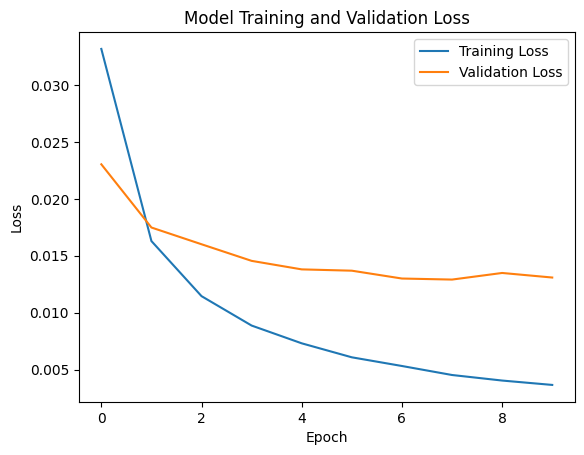

In [21]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"], loc="upper right")
plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 776us/step


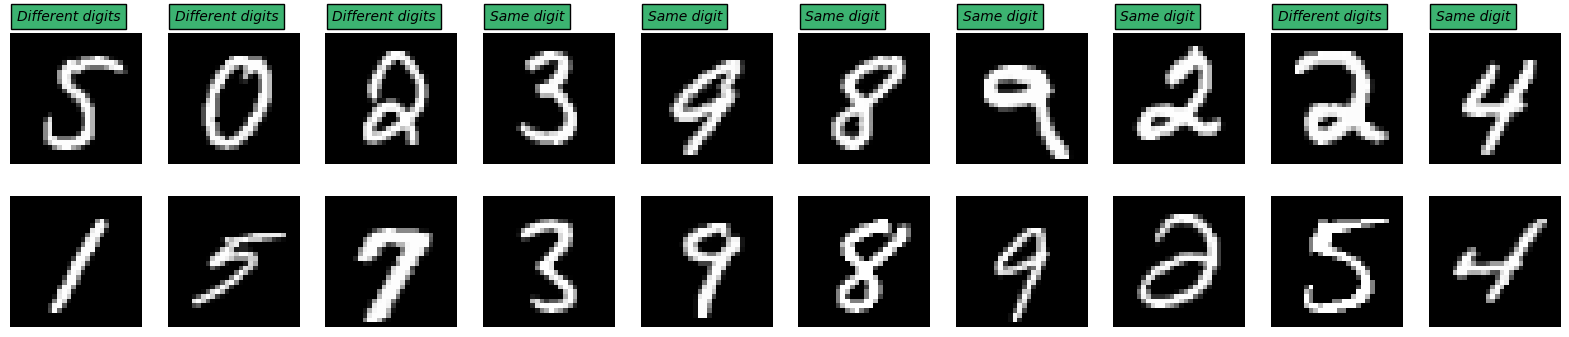

In [22]:
# Evaluate the model using the test set and visualize the predictions
predictions = model.predict([X_test_pairs[:, 0], X_test_pairs[:, 1]]) >= 0.5 # Predict whether the distance is less than 0.5
visualize_pairs(
    X=X_test_pairs,
    y=predictions,
    correct=predictions == y_test_pairs,
) # Visualize the pairs

In [25]:
# Compute the accuracy of the model on the test set
accuracy = keras.metrics.BinaryAccuracy()
accuracy.update_state(y_test_pairs, predictions.astype(int))
print(f"Accuracy: {accuracy.result().numpy():.2f}")

Accuracy: 0.97


In [26]:
model.layers

[<InputLayer name=input_layer, built=True>,
 <InputLayer name=input_layer_1, built=True>,
 <Sequential name=sequential, built=True>,
 <Lambda name=lambda, built=True>]

In [27]:
# Extract the Sequential model from the Siamese network to generate embeddings for new images
embedding_model = model.layers[2]

Select two random images representing the digit `4`, and one representing the digit `9`

In [28]:
digits = np.where(y_test == 4)[0]   # Select images of the digit 4
index_1 = np.random.choice(digits)  # Select a random image of the digit 4
index_2 = np.random.choice(digits)  # Select another random image of the digit 4
index_3 = np.random.choice(np.where(y_test == 9)[0])  # Select a random image of the digit 9

index_1, index_2, index_3

(4468, 6185, 1631)

In [29]:
# Generate embeddings for the selected images
embedding_1 = embedding_model.predict(X_test[index_1].reshape(1, -1))
embedding_2 = embedding_model.predict(X_test[index_2].reshape(1, -1))
embedding_3 = embedding_model.predict(X_test[index_3].reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


The distances between the embeddings of the images representing digit `4` and digit `9` should be enormous (close to 1)

In [34]:
norm(embedding_1 - embedding_3).numpy(), norm(embedding_2 - embedding_3).numpy()

(0.9287896, 0.8867112)

The distance between embeddings of the two images represnting the `4` should be really small (close to 0)

In [35]:
norm(embedding_1 - embedding_2).numpy()

0.043126985